In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from function_utils import display_circles, plot_dendrogram

In [2]:
sns.set_palette("Pastel2")

In [3]:
df = pd.read_csv("datasets/data_segmentation.csv")
df.set_index("customer_id", inplace=True)
df.head(3)

,Recency,Frequency,MonetaryValue
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,338,1,114.74
000161a058600d5901f007fab4c27140,459,1,67.41
0001fd6190edaaf884bcaf3d49edf079,597,1,195.42


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, 00012a2ce6f8dcda20d059ce98491703 to ffffe8b65bbe3087b653a978c870db99
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        99440 non-null  int64  
 1   Frequency      99440 non-null  int64  
 2   MonetaryValue  99440 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.0+ MB


# Préparation des données

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=.25, random_state=42)

In [6]:
train_set.shape

(74580, 3)

In [7]:
from scipy import stats

customers = pd.DataFrame()
customers["Recency"] = np.log1p(train_set['Recency'])
customers["Frequency"] = np.log1p(train_set["Frequency"])
customers["MonetaryValue"] =np.log1p(train_set["MonetaryValue"])
customers.tail()

,Recency,Frequency,MonetaryValue
customer_id,,,
104a2c4dd474047d0e06b3b120d5a740,5.365976,0.693147,5.214827
8db09297f613aa7c953b997e92b750db,6.333280,2.197225,2.524228
c4fa4315b879e1c56f1d536e67d4f8ec,5.356586,0.693147,4.857562
022aad8457b9fe76c22eaa3cbaf5b6e5,6.236370,0.693147,4.992811
28aa752efb79504ee5814c07f649b617,5.613128,0.693147,3.774598


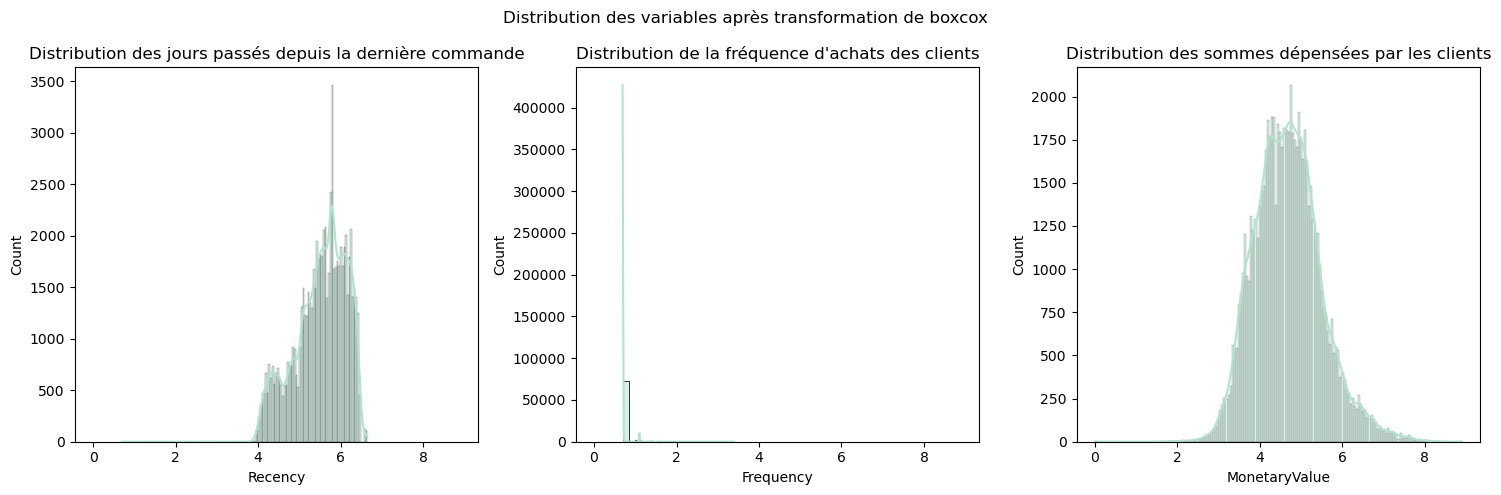

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('Distribution des variables après transformation de boxcox')

sns.histplot(ax=axes[0],x="Recency", data=customers, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.histplot(ax=axes[1],x="Frequency", data=customers, kde=True)
axes[1].set_title("Distribution de la fréquence d'achats des clients")

sns.histplot(ax=axes[2],x="MonetaryValue", data=customers, kde=True)
axes[2].set_title("Distribution des sommes dépensées par les clients")

plt.tight_layout()
plt.show();

- Standardisation

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(customers)
customers_normalized = scaler.transform(customers)

print("Mean:", customers_normalized.mean(axis=0).round(2))
print("Standard Deviation:", customers_normalized.std(axis=0).round(2))

Mean: [-0.  0. -0.]
Standard Deviation: [1. 1. 1.]


# Réduction de dimensions

In [10]:
from sklearn.decomposition import PCA

n_comp = 2
pca = PCA(n_components = n_comp)
features = customers.columns
data_pca = pca.fit_transform(customers_normalized)
pcs = pca.components_

In [11]:
#display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Modélisation

## K-Means

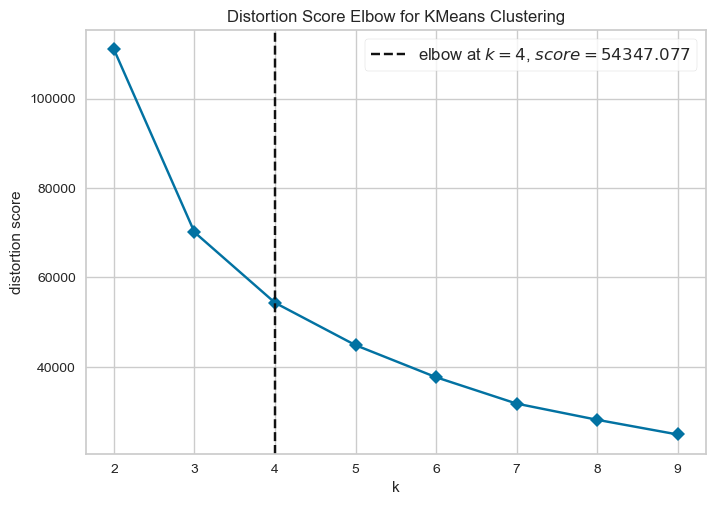

In [12]:
# Elbow method pour déterminer le nombre de clusters optimale
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k =(2, 10), timings=False)
visualizer.fit(data_pca)
visualizer.show();

In [13]:
sns.set_palette("Pastel2")

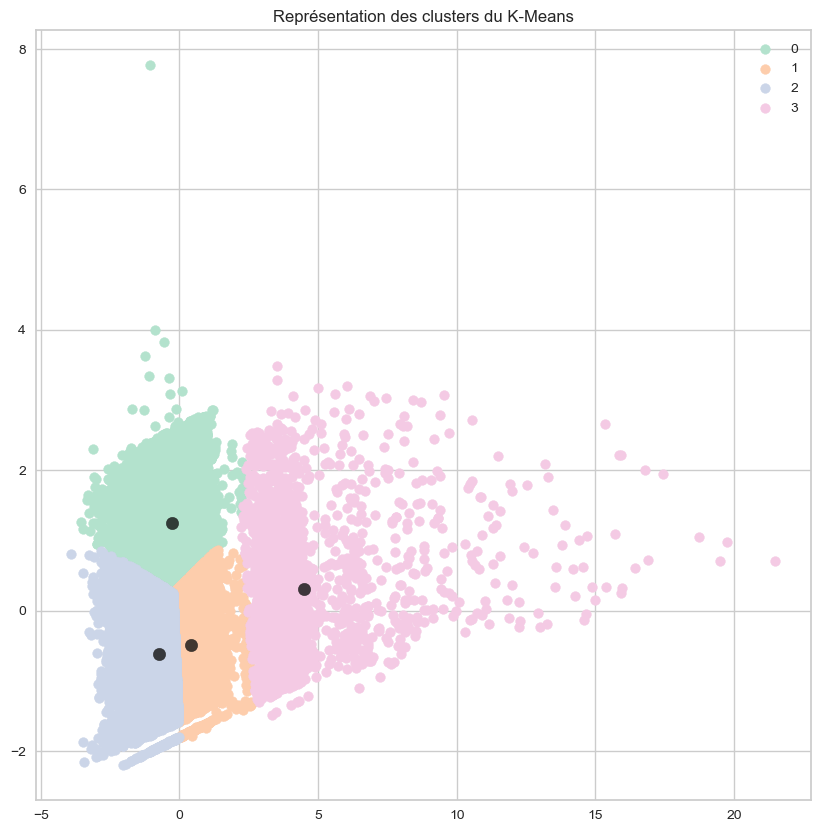

In [14]:
# Calcul du K-Means et affectation du cluster à chaque bâtiment
km = KMeans(n_clusters=4)

#Prédiction
label = km.fit_predict(data_pca)
 
centroids = km.cluster_centers_
u_labels = np.unique(label)

#Représentation graphique:

plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(data_pca[label == i , 0] , data_pca[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
#plt.savefig("Présentation/Images/representation_kmeans.png")
plt.show();

### Description des clusters obtenus avec le modèle

In [15]:
train_set["Cluster"] = km.labels_
train_set.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': ["mean", "count"]}).round(2)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0        120.64      1.00        141.09  21769
1        370.63      1.00         69.54  28826
2        353.21      1.00        301.87  21950
3        315.61      2.51         51.51   2035

In [16]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = train_set.index
df_normalized["Cluster"] = km.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars = ["Recency", "Frequency", "MonetaryValue"],
                      var_name = "Attribute",
                      value_name = "Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,6724e5d010a374b2048e209baefe6784,0,Recency,-1.857344
1,4ec1c641f6c10ee8966cef37f71be2e7,1,Recency,0.218122
2,7715f80f77f2ebf4583f97a0a6a7548b,1,Recency,0.285670
3,c8cd50dc061e703f567e2b908868a836,0,Recency,-1.681858
4,98980a9f930887243ad599ff2eae3609,0,Recency,-1.963691


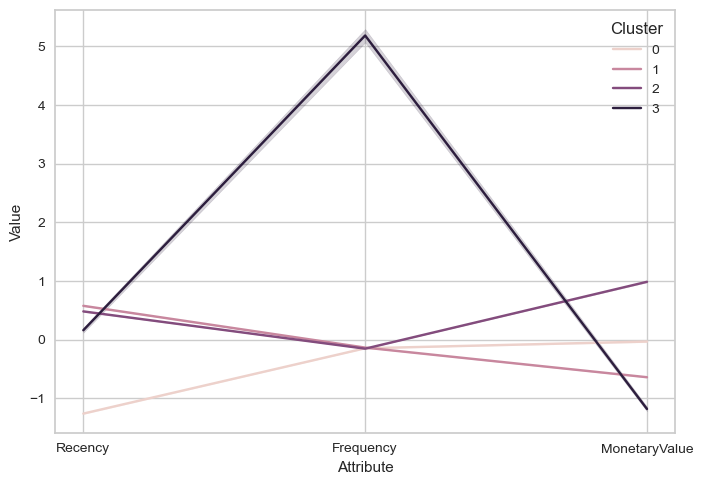

In [17]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.show()

### Evaluation du modèle

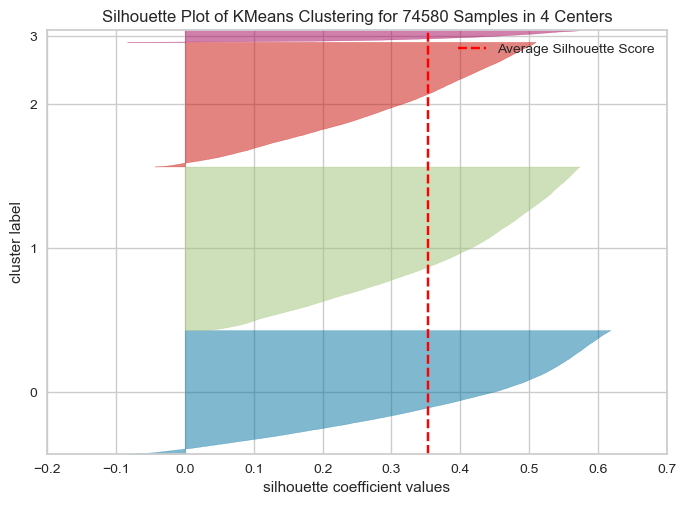

In [18]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')

visualizer.fit(data_pca)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print("Silhouette Score:", silhouette_score(data_pca, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(data_pca, label))

Silhouette Score: 0.3529951207460695
Score de Davies-Bouldin: 0.8861591286907518


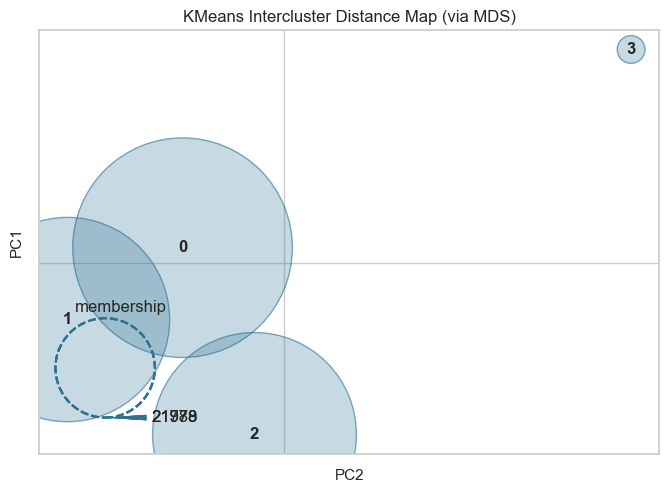

In [20]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(4, random_state=42), data_pca);

## DBSCAN

In [21]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.5, min_samples=10)
db.fit(customers_normalized)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [22]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

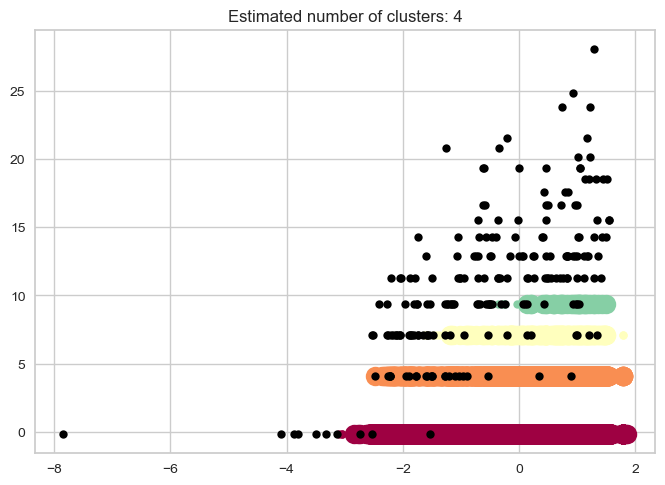

In [23]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = customers_normalized[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = customers_normalized[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Evaluation du modèle

In [24]:
visualizer = SilhouetteVisualizer(db, colors='yellowbrick')

visualizer.fit(data_pca)
visualizer.show();

AttributeError: 'DBSCAN' object has no attribute 'n_clusters'

In [ ]:
print("Silhouette Score:", silhouette_score(data_pca, labels))
print("Score de Davies-Bouldin:", davies_bouldin_score(data_pca, labels))

In [ ]:
intercluster_distance(DBSCAN(eps=0.5, min_samples=10), data_pca);